<a href="https://colab.research.google.com/github/aatmasidha/BERTEmotionAnalysis/blob/main/BERT_Eomotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import subprocess
import sys

import logging
import sys
from textwrap import TextWrapper

import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
!pip install transformers==4.13.0
import transformers
from IPython.display import set_matplotlib_formats


is_colab = "google.colab" in sys.modules
is_kaggle = "kaggle_secrets" in sys.modules

# torch-scatter binaries depend on the torch and CUDA version, so we define the
# mappings here for Colab & Kaggle
torch_to_cuda = {"1.10.0": "cu113", "1.9.0": "cu111", "1.9.1": "cu111"}
is_gpu_available = torch.cuda.is_available()
# torch-scatter binaries depend on the torch and CUDA version, so we define the
# mappings here for Colab & Kaggle


transformers_cmd = "python -m pip install transformers==4.13.0".split()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 28.7 MB/s 
     |████████████████████████████████| 3.3 MB 58.8 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 880 kB 52.6 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f5e364a40bec39439ddb0df92cc2684a33c6a3b9ecfdfb4311731b3572bff87b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
print("⏳ Installing base requirements ...")

# transformers[tf,torch,sentencepiece,vision,optuna,sklearn,onnxruntime]==4.11.3

# matplotlib
# ipywidgets
# umap-learn==0.5.1


!pip install datasets[audio]==1.16.1 
!pip install umap-learn==0.5.1
!pip install ipywidgets
!pip install matplotlib
!pip install tf==4.11.3
!pip install torch==4.11.3
!pip install sentencepiece==4.11.3
!pip install vision==4.11.3
!pip install optuna==4.11.3
!pip install sklearn==4.11.3
!pip install onnxruntime==4.11.3

import huggingface_hub
print("⏳ Installing Git LFS ...")
process_lfs = subprocess.run(["apt", "install", "git-lfs"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if process_lfs.returncode == -1:
    raise Exception("😭 Failed to install Git LFS and soundfile")
else:
    print("✅ Git LFS installed!")

process_scatter = subprocess.run(
    transformers_cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

⏳ Installing base requirements ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 298 kB 28.9 MB/s 
     |████████████████████████████████| 141 kB 69.8 MB/s 
     |████████████████████████████████| 212 kB 66.4 MB/s 
     |████████████████████████████████| 115 kB 72.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 23.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76565 sha256=1c6e35ca63c0e6a930c1bd38160a97cd2ef1e1bbaa96954d7b61814c6572f961
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=60d96e294fcec146c86bbc8e275271bfa2b8a33e036320779ede65c6015bb

In [4]:
def display_library_version(library):
    print(f"Using {library.__name__} v{library.__version__}")

In [5]:
def set_plot_style():
    install_mpl_fonts()
    set_matplotlib_formats("pdf", "svg")
    plt.style.use("plotting.mplstyle")
    logging.getLogger("matplotlib").setLevel(level=logging.ERROR)


# Text Classification

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. Chances are that your email program's spam filter is using text classification to protect your inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which (as we saw in <<chapter_introduction>>) aims to identify the polarity of a given text. For example, a company like Tesla might analyze Twitter posts like the one in <<tesla-tweet>> to determine whether people like its new car roofs or not.

Now imagine that you are a data scientist who needs to build a system that can automatically identify emotional states such as "anger" or "joy" that people express about your company's product on Twitter. In this chapter, we'll tackle this task using a variant of BERT called DistilBERT.footnote:[V. Sanh et al., ["DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter"](https://arxiv.org/abs/1910.01108), (2019).] The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A _checkpoint_ corresponds to the set of weights that are loaded into a given transformer architecture.

This will also be our first encounter with three of the core libraries from the Hugging Face ecosystem: image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers. As shown in  <<hf-libraries>>, these libraries will allow us to quickly go from raw text to a fine-tuned model that can be used for inference on new tweets. So, in the spirit of Optimus Prime, let's dive in, "transform, and roll out!"footnote:[Optimus Prime is the leader of a race of robots in the popular Transformers franchise for children (and for those who are young at heart!).]

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="images/chapter02_hf-libraries.png" id="hf-libraries"/>

## The Dataset

To build our emotion detector we'll use a great dataset from an article that explored how emotions are represented in English Twitter messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," _Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing_ (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.] Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

In [9]:

from datasets.features.features import ClassLabel
!pip install datasets

import pandas as pd
from datasets import load_dataset
emotions = load_dataset('text', data_files={'train': '/content/dataset/train.txt', 'validation' : '/content/dataset/val.txt','test': '/content/dataset/val.txt'})
emotions['train'].features
class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

emotions = load_dataset('csv', data_files={'train': '/content/dataset/train.txt', 'validation' : '/content/dataset/val.txt','test': '/content/dataset/val.txt'}, 
                       delimiter=';', column_names=['text','label'])

from datasets import Features
features = Features({'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)})
features

# ClassLabel = (num_classes=6, )
emotions = emotions.class_encode_column("label")


df = emotions["train"].to_pandas()
labels = df['label'].unique().tolist()

emotions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-67acace4083d6373/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d4580cd52a8cf6fa/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Casting to class labels:   0%|          | 0/17 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16001
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

If we look inside our `emotions` object:

In [10]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16001
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [11]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16001
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [12]:
len(train_ds)

16001

or access a single example by its index:

In [13]:
train_ds[0]

{'label': 4, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [14]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that image:images/logo.png[hf,13,13] Datasets is based on [_Apache Arrow_](https://arrow.apache.org/), which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [16]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], names_file=None, id=None)}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [17]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [4, 4, 0, 3, 0]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [18]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


Now that we've seen how to load and inspect data with image:images/logo.png[hf,13,13] Datasets, let's do a few sanity checks about the content of our tweets.

### From Datasets to DataFrames

Although image:images/logo.png[hf,13,13] Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, image:images/logo.png[hf,13,13] Datasets provides a `set_format()` method that allows us to change the _output format_ of the `Dataset`. Note that this does not change the underlying _data format_ (which is an Arrow table), and you can switch to another format later if needed:

In [19]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:

In [20]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,4,sadness
1,i can go from feeling so hopeless to so damned...,4,sadness
2,im grabbing a minute to post i feel greedy wrong,0,anger
3,i am ever feeling nostalgic about the fireplac...,3,love
4,i am feeling grouchy,0,anger


Before diving into building a classifier, let's take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post ["A Recipe for Training Neural Networks"](https://karpathy.github.io/2019/04/25/recipe), becoming "one with the data" is an essential step for training great models!

### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one. 

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

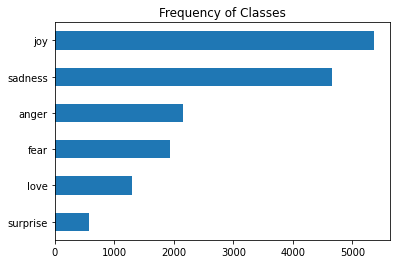

In [21]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

* Randomly oversample the minority class.
* Randomly undersample the majority class.
* Gather more labeled data from the underrepresented classes.

To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the [Imbalanced-learn library](https://imbalanced-learn.org/stable/). Just make sure that you don't apply sampling methods _before_ creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


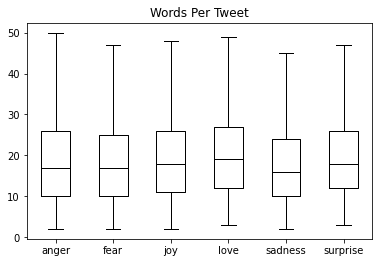

In [22]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue. 

Let's now figure out how we can convert these raw texts into a format suitable for image:images/logo.png[hf,13,13] Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the `DataFrame` format anymore: 

In [23]:
emotions.reset_format()

## From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been _tokenized_ and _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: _character_ and _word_ tokenization.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. image:images/logo.png[hf,13,13] Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [25]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [26]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [27]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [28]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. <<attention-mask>> provides a visual explanation of how the input IDs and attention masks are padded.

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="images/chapter02_attention-mask.png" id="attention-mask"/> 

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [29]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [31]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'text']


> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

As discussed in <<chapter_introduction>>, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in <<encoder-classifier>>. 

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="images/chapter02_encoder-classifier.png" id="encoder-classifier"/>

First, the text is tokenized and represented as one-hot vectors called _token encodings_. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to _token embeddings_, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a _hidden state_ for each input token. For the pretraining objective of language modeling,&#x2060;footnote:[In the case of DistilBERT, it's guessing the masked tokens.] each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

> note: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in <<chapter_anatomy>> when we use the `nn.Embedding` class.

We have two options to train such a model on our Twitter dataset:

- _Feature extraction_:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- _Fine-tuning_:: We train the whole model end-to-end, which also updates the parameters of the pretrained model. 

In the following sections we explore both options for DistilBERT and examine their trade-offs. 

### Transformers as Feature Extractors


Using a transformer as a feature extractor is fairly simple. As shown in <<encoder-features>>, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="images/chapter02_encoder-feature-based.png" id="encoder-features"/>

#### Using pretrained models


We will use another convenient auto class from image:images/logo.png[hf,13,13] Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [32]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()` method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

### Sidebar: Interoperability Between Frameworks

Although the code in this book is mostly written in PyTorch, image:images/logo.png[hf,13,13] Transformers provides tight interoperability with TensorFlow and JAX. This means that you only need to change a few lines of code to load a pretrained model in your favorite deep learning framework! For example, we can load DistilBERT in TensorFlow by using the `TFAutoModel` class as follows: 

In [33]:
#hide_output
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### End sidebar

#### Extracting the last hidden states

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new `hidden_state` column that stores all these vectors. As we did with the tokenizer, we'll use the `map()` method of `DatasetDict` to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [34]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mask` columns to the `"torch"` format, as follows:

In [35]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [36]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Note that we did not set `batch_size=None` in this case, so the default `batch_size=1000` is used instead. As expected, applying the +extract_&#x200b;hid&#x2060;den_&#x200b;states()+ function has added a new `hidden_state` column to our dataset:

In [37]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look.

#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format as follows:

In [38]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16001, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this.

#### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful UMAPfootnote:[L. McInnes, J. Healy, and J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426), (2018).] algorithm to project the vectors down to 2D.  Since UMAP works best when the features are scaled to lie in the [0,1] interval, we'll first apply a `MinMaxScaler` and then use the UMAP implementation from the `umap-learn` library to reduce the hidden states:

In [39]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.417715,6.362155,4
1,-2.742300,5.669633,4
2,5.375173,2.720793,0
3,-2.398761,3.195258,3
4,-3.342697,3.808743,0


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

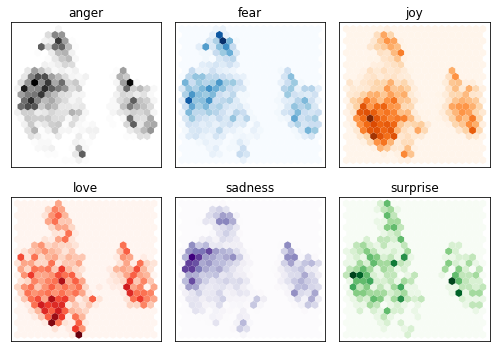

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


>note: These are only projections onto a lower-dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely, if they are separable in the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the negative feelings such as `sadness`, `anger`, and `fear` all occupy similar regions with slightly varying distributions. On the other hand, `joy` and `love` are well separated from the negative emotions and also share a similar space. Finally, `surprise` is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

Now that we've gained some insight into the features of our dataset, let's finally train a model on it!

#### Training a simple classifier


We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [41]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [42]:
lr_clf.score(X_valid, y_valid)

0.6335

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [43]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

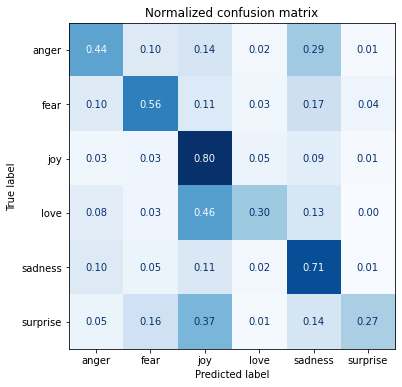

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in <<encoder-tuning>>. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="images/chapter02_encoder-fine-tuning.png" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from image:images/logo.png[hf,13,13] Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [45]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [46]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [47]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [48]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`: 

In [49]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/aatmasidha/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.58k/255M [00:00<?, ?B/s]

Download file runs/Jul11_19-15-38_21a9215ad328/events.out.tfevents.1657567046.21a9215ad328.73.0:  38%|###8    …

Download file runs/Aug05_15-12-27_0df7eb7ea9ca/events.out.tfevents.1659712433.0df7eb7ea9ca.74.0:  68%|######7 …

Download file runs/Jul11_19-15-38_21a9215ad328/1657567046.9059854/events.out.tfevents.1657567046.21a9215ad328.…

Clean file runs/Jul11_19-15-38_21a9215ad328/events.out.tfevents.1657567046.21a9215ad328.73.0:  21%|##1       |…

Download file runs/Jul11_13-49-35_6ac091ecc8d6/events.out.tfevents.1657547484.6ac091ecc8d6.72.0:  38%|###8    …

Clean file runs/Aug05_15-12-27_0df7eb7ea9ca/events.out.tfevents.1659712433.0df7eb7ea9ca.74.0:  21%|##1       |…

Download file runs/Jul12_08-25-39_6b641fc62ab7/events.out.tfevents.1657614438.6b641fc62ab7.71.0:  38%|###8    …

Clean file runs/Jul11_19-15-38_21a9215ad328/1657567046.9059854/events.out.tfevents.1657567046.21a9215ad328.73.…

Clean file runs/Jul11_13-49-35_6ac091ecc8d6/events.out.tfevents.1657547484.6ac091ecc8d6.72.0:  21%|##1       |…

Download file runs/Jul11_10-29-31_02a68c072eef/events.out.tfevents.1657535393.02a68c072eef.72.0:  38%|###8    …

Clean file runs/Jul12_08-25-39_6b641fc62ab7/events.out.tfevents.1657614438.6b641fc62ab7.71.0:  21%|##1       |…

Clean file runs/Jul11_10-29-31_02a68c072eef/events.out.tfevents.1657535393.02a68c072eef.72.0:  21%|##1       |…

Download file runs/Jul23_11-36-34_1dca5c2fcc22/events.out.tfevents.1658576310.1dca5c2fcc22.73.0:  73%|#######3…

Clean file runs/Jul23_11-36-34_1dca5c2fcc22/events.out.tfevents.1658576310.1dca5c2fcc22.73.0:  21%|##1       |…

Download file runs/Jul11_10-29-31_02a68c072eef/1657535393.7586517/events.out.tfevents.1657535393.02a68c072eef.…

Clean file runs/Jul11_10-29-31_02a68c072eef/1657535393.7586517/events.out.tfevents.1657535393.02a68c072eef.72.…

Download file runs/Jul12_08-25-39_6b641fc62ab7/1657614438.3205884/events.out.tfevents.1657614438.6b641fc62ab7.…

Download file runs/Aug05_15-12-27_0df7eb7ea9ca/1659712433.337223/events.out.tfevents.1659712433.0df7eb7ea9ca.7…

Clean file runs/Jul12_08-25-39_6b641fc62ab7/1657614438.3205884/events.out.tfevents.1657614438.6b641fc62ab7.71.…

Download file runs/Jul11_13-49-35_6ac091ecc8d6/1657547484.5926912/events.out.tfevents.1657547484.6ac091ecc8d6.…

Clean file runs/Aug05_15-12-27_0df7eb7ea9ca/1659712433.337223/events.out.tfevents.1659712433.0df7eb7ea9ca.74.1…

Download file runs/Jul23_11-36-34_1dca5c2fcc22/1658576310.7824292/events.out.tfevents.1658576310.1dca5c2fcc22.…

Clean file runs/Jul11_13-49-35_6ac091ecc8d6/1657547484.5926912/events.out.tfevents.1657547484.6ac091ecc8d6.72.…

Download file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

Clean file runs/Jul23_11-36-34_1dca5c2fcc22/1658576310.7824292/events.out.tfevents.1658576310.1dca5c2fcc22.73.…

Clean file training_args.bin:  35%|###4      | 1.00k/2.86k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.862200,0.325557,0.907500,0.906002
2,0.257700,0.221528,0.924500,0.924555


Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [50]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [51]:
preds_output.metrics

{'test_accuracy': 0.9245,
 'test_f1': 0.9245546559098581,
 'test_loss': 0.2215278595685959,
 'test_runtime': 4.5127,
 'test_samples_per_second': 443.192,
 'test_steps_per_second': 7.091}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [52]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

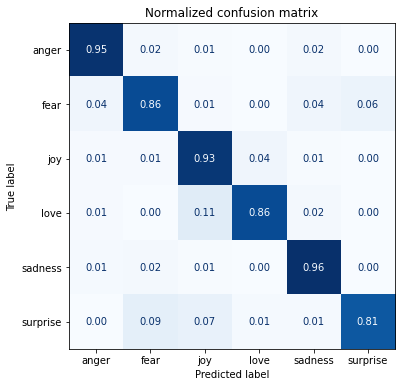

In [53]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

### Sidebar: Fine-Tuning with Keras

If you are using TensorFlow, it's also possible to fine-tune your models using the Keras API. The main difference from the PyTorch API is that there is no `Trainer` class, since Keras models already provide a built-in `fit()` method. To see how this works, let's first load  DistilBERT as a TensorFlow model:

In [54]:
#hide_output
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

Next, we'll convert our datasets into the `tf.data.Dataset` format. Since we have already padded our tokenized inputs, we can do this easily by applying the `to_tf_dataset()` method to `emotions_encoded`:

In [55]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

Here we've also shuffled the training set, and defined the batch size for it and the validation set. The last thing to do is compile and train the model:

In [56]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 150s 547ms/step - loss: 0.5185 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.1723 - val_sparse_categorical_accuracy: 0.9310
Epoch 2/2
250/250 [==============================] - 134s 537ms/step - loss: 0.1392 - sparse_categorical_accuracy: 0.9399 - val_loss: 0.1588 - val_sparse_categorical_accuracy: 0.9345


### End sidebar

#### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [57]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method once more, we can apply this function to get the losses for all the samples:

In [58]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [59]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:

- _Wrong labels_:: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

- _Quirks of the dataset_:: Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have a big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [60]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.598086
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.483011
1950,i as representative of everything thats wrong ...,surprise,sadness,5.279457
1509,i guess this is a memoir so it feels like that...,joy,fear,5.124830
1274,i am going to several holiday parties and i ca...,joy,sadness,4.993395
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.802528
1801,i feel that he was being overshadowed by the s...,love,sadness,4.737253
1683,i had applied for a job and they had assured m...,anger,joy,4.606976
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.301817
1836,i got a very nasty electrical shock when i was...,fear,anger,4.142164


We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, `joy` seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness` class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let's also look at the predictions with the smallest loss:

In [61]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.017861
19,i had lunch with an old friend and it was nice...,joy,joy,0.018533
1615,ive already noticed that ive lost weight i fee...,joy,joy,0.018734
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.018790
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.018919
1090,i dont know what it is about me and sweets the...,joy,joy,0.019064
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.019073
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.019086
632,i feel he is an terrific really worth bet,joy,joy,0.019273
856,i feel is more energetic in urban singapore th...,joy,joy,0.019287


We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about. 

The last step before serving the trained model is to save it for later usage. image:images/logo.png[hf,13,13] Transformers allows us to do this in a few steps, which we'll show you in the next section.

#### Saving and sharing the model


The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [62]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Aug14_14-26-59_653a22db7960/events.out.tfevents.1660487347.653a22db7960.71.0:  70%|#######   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/aatmasidha/distilbert-base-uncased-finetuned-emotion
   c6086b1..6478159  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/aatmasidha/distilbert-base-uncased-finetuned-emotion
   c6086b1..6478159  main -> main

To https://huggingface.co/aatmasidha/distilbert-base-uncased-finetuned-emotion
   6478159..d92afa1  main -> main

   6478159..d92afa1  main -> main



'https://huggingface.co/aatmasidha/distilbert-base-uncased-finetuned-emotion/commit/64781592d73d22dce38ad1c71990b97c6e17220b'

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [63]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/872 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Then let's test the pipeline with a sample tweet:

In [64]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:

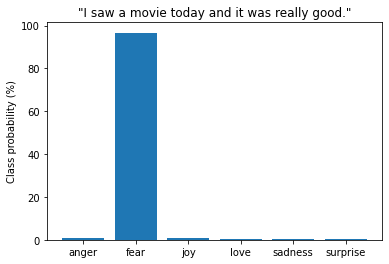

In [65]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

Congratulations, you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses. 

However, this is just the first step in building a real-world application with transformer models, and we have a lot more ground to cover. Here's a list of challenges you're likely to experience in your NLP journey:

My boss wants my model in production yesterday!::
In most applications, your model doesn't just sit somewhere gathering dust - you want to make sure it's serving predictions! When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the [documentation](https://api-inference.huggingface.co/docs/python/html/index.html) of the Inference API if you want to learn more. 

My users want faster predictions!::
We've already seen one approach to this problem: using DistilBERT. In <<chapter_compression>> we'll dive into knowledge distillation (the process by which DistilBERT was created), along with other tricks to speed up your transformer models.


Can your model also do X?::
As we've alluded to in this chapter, transformers are extremely versatile. In the rest of the book we will be exploring a range of tasks, like question answering and named entity recognition, all using the same basic architecture.

None of my texts are in English!::
It turns out that transformers also come in a multilingual variety, and we'll use them in <<chapter_ner>> to tackle several languages at once.

I don't have any labels!::
If there is very little labeled data available, fine-tuning may not be an option. In <<chapter_fewlabels>>, we'll explore some techniques to deal with this situation.

Now that we've seen what's involved in training and sharing a transformer, in the next chapter we'll explore implementing our very own transformer model from scratch.